# ***XG-Boost***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
import pickle  # For saving and loading the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
import optuna
from sklearn.ensemble import RandomForestClassifier

import os
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import optuna
import joblib
import time
import numpy as np
pd.options.display.float_format = '{:.3f}'.format

In [2]:
df = pd.read_excel("../Preprocessed data.xlsx")
#df.columns

Sizes:
 - Training: 22243
 - Validation: 4767
 - Testing: 4767
Model found. Loading from ../Models/xg_model_Unbalanced_cv.pkl...
Study found. Loading from ../Study/optuna_study_XG_Unbalanced_cv.pkl...

Validation Metrics:
F1-Score (Validation): 0.8783
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3211
           1       0.80      0.70      0.74       970
           2       0.83      0.72      0.77       586

    accuracy                           0.88      4767
   macro avg       0.85      0.80      0.82      4767
weighted avg       0.88      0.88      0.88      4767



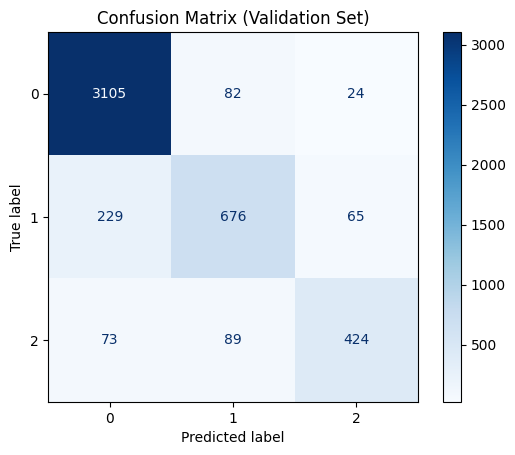

In [3]:
import os
import joblib
import xgboost as xgb
import pandas as pd
import optuna
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import time
from imblearn.over_sampling import ADASYN

# Cargar el dataset
X = df.drop(columns=["Cuenta", "Estado"])
y = df["Estado"]

# Dividir en conjunto de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Verificar el balance de clases
print(f"Sizes:\n - Training: {len(X_train)}\n - Validation: {len(X_val)}\n - Testing: {len(X_test)}")

# Definir nombres de archivos
model_filename = "../Models/xg_model_Unbalanced_cv.pkl"
study_filename = "../Study/optuna_study_XG_Unbalanced_cv.pkl"

# Verificar si el modelo o el estudio existen
model_exists = os.path.exists(model_filename)
study_exists = os.path.exists(study_filename)

if model_exists:
    print(f"Model found. Loading from {model_filename}...")
    xg_model_unbalaced = joblib.load(model_filename)
else:
    print("Model not found. A new one will be trained.")

if study_exists:
    print(f"Study found. Loading from {study_filename}...")
    study_xg_unbalanced = joblib.load(study_filename)
else:
    print("Study not found. A new one will be created.")
    pruner = optuna.pruners.MedianPruner()
    study_xg_unbalanced = optuna.create_study(direction="maximize", pruner=pruner)

    def objective(trial):
        param = {
            "verbosity": 0,
            "objective": "multi:softprob",
            "num_class": 3,
            "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            "subsample": trial.suggest_float("subsample", 0.3, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "max_depth": trial.suggest_int("max_depth", 2, 7),
            "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1),
            "num_boost_round": trial.suggest_int("num_boost_round", 50, 150),  
            "tree_method": "hist",
            "device": "cuda",
        }

        f1_scores = []
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        for train_idx, val_idx in kfold.split(X_train, y_train):
            X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
            X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
            
            dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
            dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
            
            model = xgb.train(
                param, dtrain, evals=[(dtrain, 'train'), (dval, 'validation')],
                num_boost_round=150, early_stopping_rounds=10, verbose_eval=False
            )
            
            y_val_pred = model.predict(dval)
            pred_labels = np.argmax(y_val_pred, axis=1)
            f1_scores.append(f1_score(y_val_fold, pred_labels, average="weighted"))

        return np.mean(f1_scores)

    if not model_exists:
        start_time = time.time()
        study_xg_unbalanced.optimize(objective, n_trials=100)
        end_time = time.time()
        joblib.dump(study_xg_unbalanced, study_filename)
        print(f"Study saved as {study_filename}")
        print(f"Optimization time: {end_time - start_time:.2f} seconds")

if not model_exists:
    best_params = study_xg_unbalanced.best_params
    xg_model_unbalaced = xgb.XGBClassifier(
        **best_params,
        random_state=42,
    )
    
    xg_model_unbalaced.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=True
    )
    joblib.dump(xg_model_unbalaced, model_filename)
    print(f"Model saved as {model_filename}")

# Evaluación en conjunto de validación
y_val_pred = xg_model_unbalaced.predict(X_val)

print("\nValidation Metrics:")
print(f"F1-Score (Validation): {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
print(classification_report(y_val, y_val_pred))

conf_matrix_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(conf_matrix_val, display_labels=xg_model_unbalaced.classes_)
disp_val.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.show()


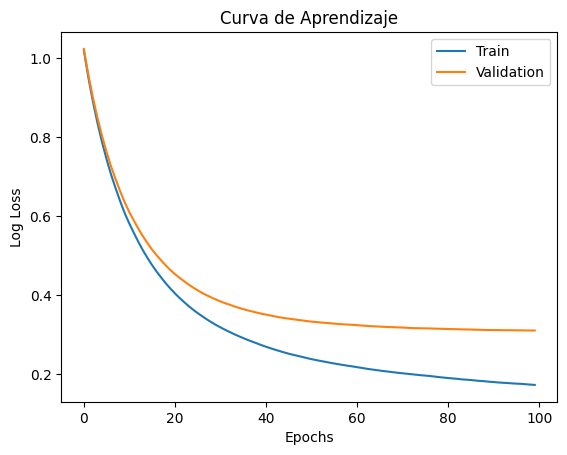

In [4]:
# Obtener el historial de evaluaciones y graficar las curvas de aprendizaje
evals_result = xg_model_unbalaced.evals_result()
# Graficar el logloss para entrenamiento y validación
epochs = len(evals_result['validation_0']['mlogloss'])
x_axis = range(0, epochs)

plt.plot(x_axis, evals_result['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, evals_result['validation_1']['mlogloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.show()

In [5]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_val, y_val_pred, "XG-Boost", "./Metrics/Train_Metrics.csv", "./Metrics/Train_Metrics.json")

📂 Reporte de XG-Boost guardado correctamente.


## ***Test Metrics***

In [6]:
# **Evaluación en el conjunto de prueba**
y_test_pred = xg_model_unbalaced.predict(X_test)

# Calcular F1-score, reporte de clasificación y matriz de confusión para `test`
f1_test = f1_score(y_test, y_test_pred, average="weighted")
print("\nTest Metrics:")
print(f"F1-Score (Test): {f1_test:.4f}")
print(classification_report(y_test, y_test_pred))




Test Metrics:
F1-Score (Test): 0.8820
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3212
           1       0.81      0.72      0.76       969
           2       0.79      0.70      0.74       586

    accuracy                           0.89      4767
   macro avg       0.84      0.80      0.82      4767
weighted avg       0.88      0.89      0.88      4767



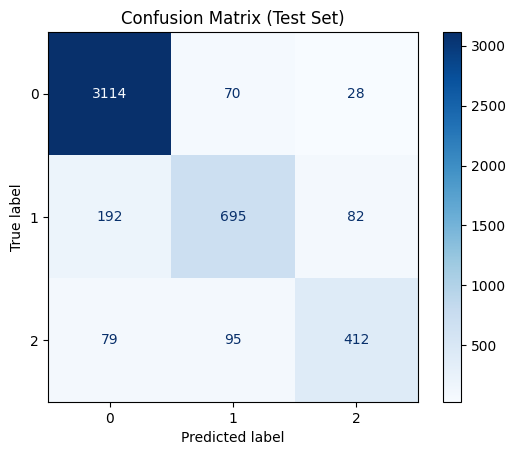

In [7]:
# Matriz de confusión para `test`
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(conf_matrix_test, display_labels=xg_model_unbalaced.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [8]:
# Análisis de errores
y_pred = xg_model_unbalaced.predict(X_test)
y_prob = xg_model_unbalaced.predict_proba(X_test)

# Identificar errores
errores_mask = y_pred != y_test
X_errores = X_test[errores_mask]
y_true_errores = y_test[errores_mask]
y_pred_errores = y_pred[errores_mask]
prob_errores = y_prob[errores_mask]

# Analizar características de los errores
for clase_real in range(3):
    for clase_predicha in range(3):
        if clase_real != clase_predicha:
            mask = (y_true_errores == clase_real) & (y_pred_errores == clase_predicha)
            if mask.any():
                print(f"\nError: Real {clase_real} -> Predicho {clase_predicha}")
                print(f"Cantidad: {mask.sum()}")
                print(f"Probabilidades medias: {prob_errores[mask].mean(axis=0)}")


Error: Real 0 -> Predicho 1
Cantidad: 70
Probabilidades medias: [0.29388928 0.6364794  0.06963129]

Error: Real 0 -> Predicho 2
Cantidad: 28
Probabilidades medias: [0.24586512 0.13963737 0.6144976 ]

Error: Real 1 -> Predicho 0
Cantidad: 192
Probabilidades medias: [0.73451066 0.20772344 0.05776596]

Error: Real 1 -> Predicho 2
Cantidad: 82
Probabilidades medias: [0.06048293 0.28342497 0.656092  ]

Error: Real 2 -> Predicho 0
Cantidad: 79
Probabilidades medias: [0.726721   0.13007441 0.14320463]

Error: Real 2 -> Predicho 1
Cantidad: 95
Probabilidades medias: [0.12211323 0.65368265 0.22420417]


## ***Optuna Visualization***

In [9]:
optuna.visualization.plot_optimization_history(study_xg_unbalanced)

In [10]:
optuna.visualization.plot_parallel_coordinate(study_xg_unbalanced)

In [11]:
# Extract F1-scores from each trial in the study
f1_scores = [study_xg_unbalanced.trials[i].value for i in range(len(study_xg_unbalanced.trials))]  # Get the F1-score for each trial

# Create a plotly figure
fig = go.Figure()

# Add a line plot to the figure with the F1-scores
fig.add_trace(go.Scatter(
    x=list(range(len(study_xg_unbalanced.trials))),  # X-axis: Trial number
    y=f1_scores,  # Y-axis: F1-score values
    mode='markers+lines',  # Display both markers and lines
    name='F1-score',  # Label for the line
    line=dict(color='blue'),  # Line color
    marker=dict(color='blue', size=6)  # Marker style
))

# Update layout for the plot
fig.update_layout(
    title="F1-Score Evolution During Optuna Optimization",  # Title of the plot
    xaxis_title="Trial",  # Label for X-axis
    yaxis_title="F1-Score",  # Label for Y-axis
    template="plotly_dark",  # Use dark template for better visibility
    showlegend=False  # Hide legend
)

# Show the plot
fig.show()


In [12]:
optuna.visualization.plot_slice(study_xg_unbalanced, params=['booster', 'lambda', 'alpha', 'subsample', 'colsample_bytree', 'max_depth', 'learning_rate', 'num_boost_round'])


In [13]:
optuna.visualization.plot_param_importances(study_xg_unbalanced)

## ***Feature Importances***

In [14]:
# Extract feature importances from the trained model
importances = xg_model_unbalaced.feature_importances_

# Create a DataFrame for easier plotting
feature_names = X_train.columns  # Use the features from the final training set
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance and select the top 20
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the feature importance using Plotly
fig = px.bar(importance_df, 
             x='Feature', 
             y='Importance', 
             title='Top 20 Feature Importance of the Decision Tree Model',
             labels={'Feature': 'Feature Name', 'Importance': 'Importance Score'},
             color='Importance',  # Color bars based on importance
             color_continuous_scale='Viridis',  # Use a color scale for better visualization
             text='Importance')  # Display importance values on the bars

# Rotate X-axis labels for better readability
fig.update_layout(xaxis_tickangle=45)

# Show the plot
fig.show()


In [15]:
importance_df_ = importance_df.sort_values(by='Importance', ascending=False)
importance_df_

,Feature,Importance
23,TotalGestionesCompromiso,0.121
20,TotalGestiones,0.068
24,TotalGestionesMasivas,0.057
8,HabitoPago03,0.053
7,HabitoPago01,0.033
18,SaldoCliente,0.031
21,TotalGestionesCD,0.026
9,HabitoPago06,0.023
11,IndiceMora,0.021
30,situacion,0.021


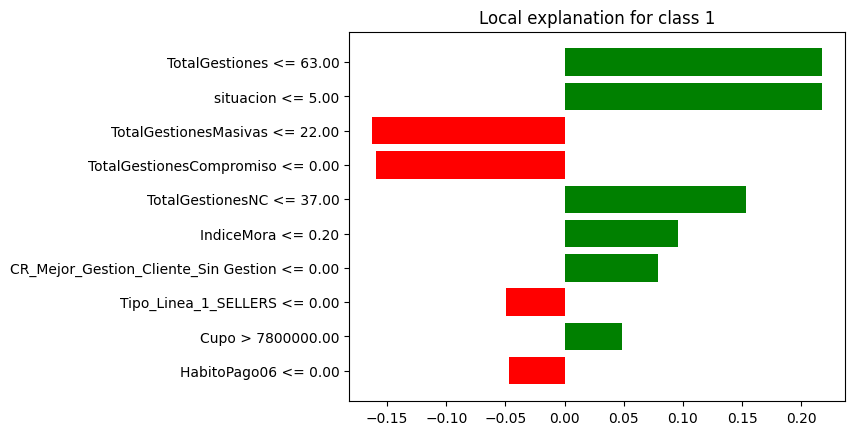

In [16]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,               # Training data (must be a numpy array or pandas dataframe)
    feature_names=X_train.columns,                    # Feature names (column names)
    class_names=y_train.unique(),                     # Target class names (unique classes in target column)
    mode='classification',                             # We're explaining a classification problem
    training_labels=y_train.values                     # Labels for training data
)

# Example 1: Explaining the prediction for the 100th instance in the test set
i = 3
instance = X_test.iloc[i].values.reshape(1, -1)  # Reshape for LIME

exp = explainer.explain_instance(
    data_row=instance[0],                           # Instance to explain
    predict_fn=xg_model_unbalaced.predict_proba              # Model's predict function (predict_proba for probabilities)
)

# Show explanation in notebook (table of feature importances)
exp.show_in_notebook(show_table=True, show_all=False)

# Generate a plot for the explanation
fig = exp.as_pyplot_figure()
plt.show()

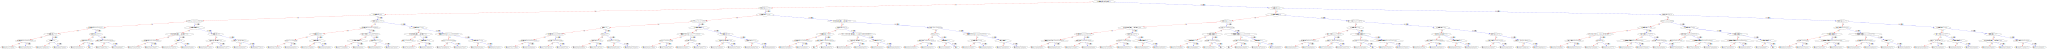

In [17]:
import graphviz

dot = xgb.to_graphviz(xg_model_unbalaced, num_trees=1)
dot.render("./img/tree_xgb")  # Guarda el gráfico en un archivo
dot  # Mostrar en Jupyter Notebook

In [18]:
xg_model_unbalaced.__sklearn_tags__

<bound method BaseEstimator.__sklearn_tags__ of XGBClassifier(alpha=0.04336956585790166, base_score=None, booster='dart',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9053953187061508, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.006581961980902845,
              learning_rate=0.07509983172509736, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)>

In [19]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_val, y_val_pred, "XG-Boost", "./Metrics/Test_Metrics.csv", "./Metrics/Test_Metrics.json")

📂 Reporte de XG-Boost guardado correctamente.


In [20]:
from reporte_metricas import cargar_reportes

cargar_reportes("./Metrics/Test_Metrics.csv")

📊 Reportes cargados correctamente: ['CART' 'KNN Model' 'LGBM Model' 'MLP' 'RF Model' 'SVC Model'
 'TAB NET Model' 'XG-Boost']


,Modelo,Clase,precision,recall,f1-score,support
0,CART,0,0.947,0.865,0.904,3212.000
1,CART,1,0.638,0.705,0.670,969.000
2,CART,2,0.585,0.765,0.663,586.000
3,CART,accuracy,0.820,0.820,0.820,0.820
4,CART,macro avg,0.724,0.778,0.746,4767.000
5,CART,weighted avg,0.840,0.820,0.827,4767.000
6,KNN Model,0,0.831,0.942,0.883,3212.000
7,KNN Model,1,0.648,0.513,0.573,969.000
8,KNN Model,2,0.565,0.343,0.427,586.000
9,KNN Model,accuracy,0.781,0.781,0.781,0.781
